# SUBGRAPH EXAMPLE


In [50]:
# COMMON IMPORTS
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode, InjectedState
from langchain.tools import tool, ToolRuntime
from langchain_community.tools.file_management.read import ReadFileTool
#from langchain_experimental.tools.python.tool import PythonREPLTool
from pydantic import BaseModel, Field
from IPython.display import display, HTML, Image
from typing_extensions import Annotated

from langchain_google_genai import ChatGoogleGenerativeAI
import os
import json
from dotenv import load_dotenv
from langchain.messages import ( 
                                    HumanMessage, 
                                    SystemMessage, 
                                    AIMessage, 
                                    ToolMessage,
                                    AnyMessage)
import subprocess

from langgraph.graph.message import add_messages 

import pandas as pd

# FILM RECOMMENDATION
This example is (the start of) a simple film recommendation application.  It takes a query (like find me a good comedy series).  The query is passed to Tavili to get a list of possible films, which are then passed to a subgraph to get details of the first three selected movies, including a summary and main actors.  Tavili is used to find the IMDB link for the film and then to get the details from the page.

This could easily be enriched to get more recommendations and add rating and reviews for each film in another subgraph.

The benefit of using a subgraph is that the application can scale to get details on any number of films, without overloading the context about all the films being researched.

In [82]:
#  Use Gemini flash lite
llm = ChatGoogleGenerativeAI(
    # model=os.getenv("GOOGLE_API_MODEL"),
    model="gemini-2.5-flash-lite",
    temperature=0)


In [77]:
load_dotenv()

True

In [78]:
# get travili client
from tavily import TavilyClient
tavily_client = TavilyClient(api_key=os.getenv("TAVILI_API_KEY"))


In [84]:
# parent graph with list of titles
# use a sub graph to get more information about each title

class MovieDetails(BaseModel):
    title: str = Field(description="The title of the movie.")
    genre: str = Field(description="The genres of the movie.")
    summary: str = Field(description="A brief summary of the movie.", default="")
    cast: list[str] = Field(description="The main cast of the movie.", default_factory=list)
    director: str = Field(description="The director of the movie.", default="")
    release_year: int = Field(description="The year the movie was released.", default=0)
    rating: str = Field(description="The movie rating.", default="")


## Tools for Tavili
Two simple tool for using Tavili.  The first performs a search for the IMDB page for the film or series.

The second tool calls tavili extract to get the content of the page at a url

In [85]:
    
# TOOLS
@tool
def tavili_search_tool(movie_title: str = Field(description="Movie title to search for the main IMDB page."),
                       number_of_results: int = Field(description="Number of search results to return")) -> str:
    """Searches Tavili for the Movie page on IMDB.  Pass the movie title as the query."""
    try:
        query = f"Get the link for the Main IMDB Page for the Title: {movie_title}"
        result = json.dumps(tavily_client.search(query=query, max_results=number_of_results)['results'])
    except Exception as e:
        result = f"Error(tavili_search_tool) : {e}"
    return "<SEARCH RESULTS>" + result + "</SEARCH RESULTS>"

@tool
def tavili_extract_tool(url: str = Field(description="URL of the page to extract information from")) -> str:
    """Extracts the main content from a given URL using Tavily."""
    try:
        result = json.dumps(tavily_client.extract(urls=[url])['results'])
    except Exception as e:
        result = f"Error(tavili_extract_tool) : {e}"
    return "<EXTRACT_RESULTS>" + result + "</EXTRACT_RESULTS>"



## Nodes of SubGraph
These are the nodes of the subgraph.  The first node creates the system and first human message, based on the query.

The second node is a tool loop, first looking up the URL and then getting the information from the URL.

The final node summarises the content of the page.  This has been put into a separate node in order to format the response into a structured output, which can be easily read and analysed in other parts of the application.

In [87]:
# NODES
# create a ReAct subgraph to get cast information for a movie title

class SubgraphState(BaseModel):
    title: str
    messages: Annotated[ list[AnyMessage], add_messages] = []
    details: MovieDetails = None
    

def start_movie_details(state: SubgraphState) -> dict:
    prompt = f"""
Your task is to get details for the movie title: {state.title} from the IMDB website.
Complete the following steps:
1. You must request the 'MAIN' page on IMDB for {state.title}.
2. With the URL, extract the main information from the page.
When you have retrieved the information provide a final answer of 'DONE'.
    """
    system_message = SystemMessage(content="You are a helpful assistant that provides movie information.")
    task = HumanMessage(content=prompt)
    return {"messages": [system_message, task]}

def get_movie_details(state: SubgraphState) -> dict:
    response = llm.bind_tools([tavili_search_tool, tavili_extract_tool]).invoke(state.messages)
    return {"messages": response}

def format_movie_details(state: SubgraphState) -> dict:
    messsage = HumanMessage(content="Read the messages prior to the message 'DONE' and summarize the movie details into the provided output format.")    
    result = llm.with_structured_output(schema=MovieDetails).invoke(input=state.messages + [messsage])
    return {"details": result}


## Build the SubGraph
Builds the nodes and edges for the subgraph.

In [88]:
# build graph to get movie details.  Start -> get_movie_details -> toolNode -> conditional edge -> format_movie_details -> END
movie_graph = StateGraph(SubgraphState)
movie_graph.add_node("start_movie_details", start_movie_details)
movie_graph.add_node("get_movie_details", get_movie_details)
movie_graph.add_node("tool_node", ToolNode(tools=[tavili_search_tool, tavili_extract_tool]))
movie_graph.add_node("format_movie_details", format_movie_details)

movie_graph.add_edge(START, "start_movie_details")
movie_graph.add_edge("start_movie_details", "get_movie_details")
movie_graph.add_conditional_edges("get_movie_details", lambda state: state.messages[-1].tool_calls != [],
                                 path_map={True: "tool_node", False: "format_movie_details"})
movie_graph.add_edge("tool_node", "get_movie_details")
movie_graph.add_edge("format_movie_details", END)
# compile subgraph
netflix_subgraph = movie_graph.compile()

## Graph Diagram

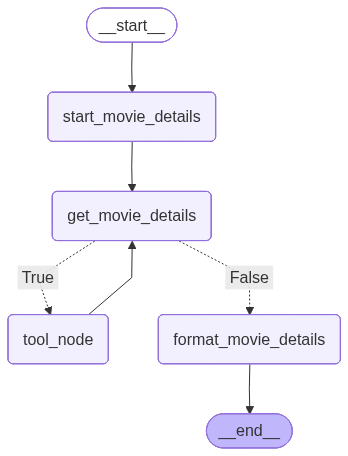

In [58]:
# draw graph
netflix_subgraph

## Testing the SubGraph
First test out the subgraph with a hard coded title.

In [89]:
# test subgraph
result = netflix_subgraph.invoke(SubgraphState(title="Stranger Things"))


In [ ]:
result

## MAIN GRAPH
The main graph will first call Tavili search to get a short list.  This is rather basic and could get and read multiple review and recommendation pages to get a better selection of films (could create another subgraph for this).

 

In [91]:
class MainGraphState(BaseModel):
    # messages: Annotated[list[AnyMessage], add_messages] = []
    titles: list[str] = Field(description="List of movie titles to get details for.")
    movie_details: dict[str, MovieDetails] = Field(description="Dictionary of movie titles to their details.", default_factory=dict)

In [92]:

class ShortListGraphState(BaseModel):
    query: str = Field(description="Query string to generate a short list of movie titles.")
    short_list: list[str] = Field(description="Short list of movie titles to process.", default_factory=list)
    search_results: str = Field(description="Raw search results from Tavili.", default="")
    movie_details: list[MovieDetails] =  []

In [93]:
# Structured output for list of titles
class ShortListTitles(BaseModel):
    titles: list[str] = Field(description="List of movie titles to get details for.")

## Nodes for Subgraph
The nodes do the following:
- create_list_of_titles:  Perform Tavili search to get list of titles
- process_results: Read and create structured results from Tavili search
- get_movie_details:  Call the subgraph to get the details for the title

In [94]:
# Node  - get recommendations
def create_list_of_taitles(state: ShortListGraphState) -> dict:
    # For testing, we will use a static list of titles
    # search tavili for titles matching query
    results = tavily_client.search(query=state.query, max_results=5)
    return {"search_results": ', '.join([result['content'] for result in results['results']]) }

def process_results(state: ShortListGraphState) -> dict:
    messsage = HumanMessage(content=f"From the search results: {state.search_results}, create a short list of movie titles to get details for.")
    result = llm.with_structured_output(schema=ShortListTitles).invoke(input=[messsage])
    return {"short_list": result.titles}

# create node to call subgraph for first 3 titles
def get_movie_details_node(state: ShortListGraphState) -> dict:
    details = []
    for title in state.short_list[:3]:
        result = netflix_subgraph.invoke(SubgraphState(title=title))
        details.append(result['details'])
    return {"movie_details": details}


In [95]:
# create graph to get short list of titles
shortlist_graph = StateGraph(ShortListGraphState)
shortlist_graph.add_node("create_list_of_titles", create_list_of_titles)
shortlist_graph.add_node("process_results", process_results)
shortlist_graph.add_node("get_movie_details", get_movie_details_node)

# edges
shortlist_graph.add_edge(START, "create_list_of_titles")
shortlist_graph.add_edge("create_list_of_titles", "process_results")
shortlist_graph.add_edge("process_results", "get_movie_details")
# compile graph
compiled_short_list = shortlist_graph.compile()


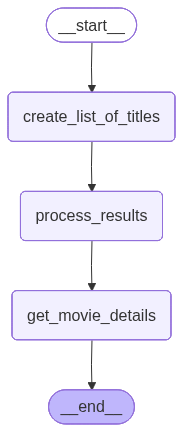

In [73]:

compiled_short_list

In [96]:
# run graph
list_of_titles_result = compiled_short_list.invoke(ShortListGraphState(query="Top rated sci-fi movies"))

In [97]:
for detailes in list_of_titles_result['movie_details']:
    print(f"Title: {detailes.title}")
    print(f"Genre: {detailes.genre}")
    print(f"Summary: {detailes.summary}")
    print(f"Cast: {', '.join(detailes.cast)}")
    print(f"Director: {detailes.director}")
    print(f"Release Year: {detailes.release_year}")
    print(f"Rating: {detailes.rating}")
    print("-" * 40)

Title: Metropolis
Genre: Sci-Fi
Summary: A futuristic city where a scientist and the city founder's son must stop the evil plans of the robot duplicate robot of the scientist's dead wife.
Cast: Unknown
Director: Unknown
Release Year: 2001
Rating: 
----------------------------------------
Title: WALL-E
Genre: Animation, Adventure, Family, Sci-Fi
Summary: A robot who is responsible for cleaning a waste-covered Earth meets another robot and falls in love with her. Together, they set out on a journey that will alter the fate of mankind.
Cast: Ben Burtt, Elissa Knight, Jeff Garlin
Director: Andrew Stanton
Release Year: 2008
Rating: 
----------------------------------------
Title: Alien
Genre: Horror, Sci-Fi
Summary: A space crew encounters a dangerous alien life form on their ship.
Cast: 
Director: 
Release Year: 1979
Rating: 
----------------------------------------
